# 02_Getting started with neural networks

## Setup

In [40]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
from IPython.display import HTML

# Common imports
import numpy as np
import os
import tensorflow as tf

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import matplotlib.image as mpimg
def plot_external(img):
    img_name = os.path.join(".", "images",img)
    plots = mpimg.imread(img_name)
    plt.axis("off")
    plt.imshow(plots)    
    plt.show()
    
def plot_external2(imgpath):    
    plots = mpimg.imread(imgpath)
    plt.axis("off")
    plt.imshow(plots)    
    plt.show()  

# batch function
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

<br><br>

## 2.1 Anatomy of a neural network

신경망 훈련에는 다음 요소들이 관련되어 있습니다.  
- 네트워크(모델)를 구성하는 층  
- 입력 데이터와 그에 상응하는 타깃  
- 학습에 사용할 피드백 신호를 정의하는 손실 함수  
- 학습 진행 방식을 결정하는 옵티마이저  

이들 간의 상호 작용은 아래 그림과 같습니다. 연속된 층으로 구성된 네트워크가 입력 데이터를 기준 예측으로 매핑합니다. 손실 함수는 예측과 타겟을 비교하여 네트워크의 예측이 기댓값에 얼마나 잘 맞는지를 측정하는 손실 값을 만듭니다. 옵티마이저는 손실값을 사용하여 네트워크 가중치를 업데이트합니다.

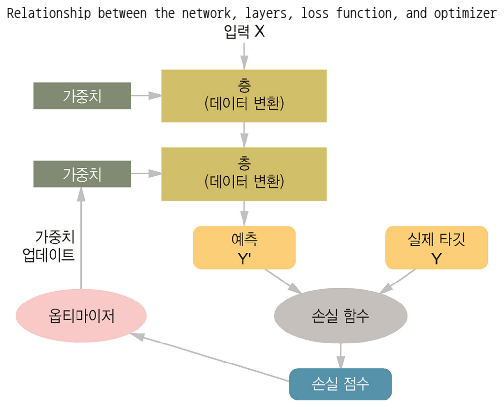

In [41]:
plt.figure(figsize=(12, 7))
plt.title("Relationship between the network, layers, loss function, and optimizer", fontsize=14)
plot_external2("./images/ch02/1.png")
plt.show()

<br>

## 2.2 Layers: the building blocks of deep learning

신경망의 핵심적인 데이터 구조는 층(layer)입니다. 층은 하나 이상의 텐서를 입력으로 받아 하나 이상의 텐서를 출력하는 데이터 처리 모듈입니다. 어떤 종류의 층은 상태가 없지만 대부분의 경우 가중치라는 층의 상태를 가집니다(Flatten, Pooling, Dropout층에는 학습되는 가중치가 없습니다). 가중치는 확률적 경사하강법에 의해 학습되는 하나 이상의 텐서이며 여기에 네트워크가 학습한 지식이 담겨 있습니다.  

층마다 적절한 텐서 포맷과 데이터 처리 방식이 다릅니다. 예를 들어 (samples, features)크기의 2D 텐서가 저장된 간단한 벡터 데이터는 완전 연결 층(fully connected layer)이나 밀집 층(dense layer)이라고도 불리는 밀집 연결층(densely connected layer)에 의해 처리되는 경우가 많습니다. (samples, timesteps, features) 크기의 3D 텐서로 저장된 시퀀스 데이터는 보통 LSTM같은 순환 층(recurrent layer)에 의해 처리됩니다. 4D 텐서로 저장되어 있는 이미지 데이터는 일반적으로 2D 합성곱 층(convolution layer)에 의해 처리됩니다(Conv2D 클래스).  

층을 딥러닝의 레고 블럭처럼 생각할 수 있습니다. 이런 비유는 케라스 같은 프레임워크 때문에 생겼습니다. 케라스에서는 호환 가능한 층들을 엮어 데이터 변환 파이프라인을 구성함으로써 딥러닝 모델을 만듭니다. 여기에서 층 호환성(layer compatibility)은 층이 특정 크기의 입력 텐서만 받고 특정 크기의 출력 텐서를 반환한다는 사실을 말합니다.

In [42]:
from tensorflow.keras import layers
layer = layers.Dense(32, input_shape=(784, ))

첫 번째 차원이 784인 2D 텐서만 입력으로 받는 층을 만들었습니다(배치 차원인 0번째 축은 지정하지 않기 때문에 어떤 배치 크기도 입력으로 받을 수 있습니다). 이 층은 첫번째 차원 크기가 32로 변환된 텐서를 출력할 것입니다. 따라서 이 층에는 32차원의 벡터를 입력으로 받는 하위 층이 연결되어야 합니다 케라스에서는 모델에 추가된 층을 자동으로 상위 층의 크기에 맞추어 줍니다.

In [43]:
model = tf.keras.Sequential()
model.add(layers.Dense(32, input_shape=(784, )))
model.add(layers.Dense(10))

두번째 층에는 input_shape 매개변수를 지정하지 않았습니다. 그 대신 앞선 층의 출력 크기를 입력 크기로 자동으로 채택합니다.

<br>

## 2.3 Models: networks of layers

딥러닝 모델은 층으로 마든 비순환 유향 그래프(Directed Acyclic Graph, DAG: 한 노드에서 다시 자기자신으로 돌아올 경로가 없는 그래프)입니다. 가장 일반적인 예가 하나의 입력을 하나의 출력으로 매핑하는 층을 순서대로 쌓는 것입니다.  

네트워크 구조는 가설 공간(hypothesis space)을 정의합니다. 네트워크 구조를 선택함으로써 가능성 있는 공간(가설 공간)을 입력 데이터에서 출력 데이터로 매핑하는 일련의 특정 텐서 연산으로 제한하게 됩니다. 우리가 찾아야 할 것은 이런 텐서 연산에 포함된 가중치텐서의 좋은 값입니다.  

딱 맞는 네트워크 구조를 찾아내는 것은 예술에 가깝습니다.

<br>

# 2.4 Loss functions and optimizers: keys to configuring the learning process

네트워크 구조를 정의하고 나면 2가지를 더 선택해야 합니다.  
- 손실 함수(loss function)(목적함수 objective function): 훈련하는 동안 최소화될 값입니다. 주어진 문제에 대한 성공 지표가 됩니다.  
- 옵티마이저(optimizer): 손실 함수를 기반으로 네트워크가 어떻게 업데이트될지 결정합니다. 특정 종류의 확률적 경사하강법(SGD)을 구현합니다.  

여러 개의 출력을 내는 신경망은 여러 개의 손실 함수를 가질 수 있습니다(출력당 하나씩). 하지만 경사 하강법 과정은 하나의 스클라 손실 값을 기준으로 합니다. 따라서 손실이 여러 개인 네트워크에서는 모든 손실이 (평균을 내서) 하나의 스칼라 양으로 합쳐집니다.  

문제에 맞는 올바른 목적 함수를 선택하는 것은 아주 중요합니다. 네트워크가 손실을 최소화하기 위해 편법을 사용할 수 있기 때문입니다. 목적 함수가 주어진 문제의 성공과 전혀 관련이 없다면 원하지 않는 일을 수행하는 모델이 만들어질 것입니다.  

2개의 클래스가 있는 분류 문제에는 "binary crossentropy", 여러개의 클래스가 있는 분류문제에서는 "categorical crossentropy", 회귀 문제에는 "RMSE(Root Mean Square Error)", 시퀀스 학습 문제이는 CTC(Connection Temporal Classification)

<br>

## 2.5 Classifying movie reviews: a binary classification example

2종 분류(two-class classification) 또는 이진 분류(binary classification)는 널리 적용된 머신러닝 문제입니다. 이 예제에서는 리뷰 텍스트를 기반으로 영화 리뷰를 긍정과 부정으로 분류합니다. 

<br>

### 2.5.1 The IMDB dataset

인터넷 영화 데이터베이스로부터 가져온 양극단의 리뷰 5만개로 이루어진 IMDB 데이터셋을 사용하겠습니다. 이 데이터셋은 훈련 데이터 2만 5천개와 테스트 데이터 2만 5천개로 나뉘어져있고 각각 50%는 부정, 50%는 긍정 리뷰로 구성되어 있습니다.  

훈련 데이터와 테스트 데이터를 나누는 이유는 같은 데이터에서 머신 러닝 모델을 훈련하고 테스트해서는 절대 안되게 때문입니다. 모델이 훈련 데이터에서 잘 작동한다는 것이 처음 만난 데이터에서도 잘 작동한다는 것을 보장하진 않습니다. 중요한 것은 새로운 데이터에 대한 모델의 성능입니다(사실 훈련 데이터의 레이블은 이미 알고 있기 때문에 이를 예측하는 모델은 필요하지 않습니다). 예를 들어 모델이 훈련 샘플과 타깃사이의 매핑을 모두 외울 수 있습니다. 이런 모델은 처음 만나는 데이터에서 타깃을 예측하는 작업에는 쓸모가 없습니다.  
이 데이터는 전처리 되어 있기 때문에 각 리뷰(단어 시퀀스)가 숫자 시퀀스로 변환되어 있습니다. 여기서 각 숫자는 사전에 있는 고유한 단어를 나타냅니다.

In [218]:
imdb = tf.keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words = 10000)

<br> 
num_words=10000 매개변수는 훈련 데이터에서 가장 자주 나타는 단어 1만 개만 사용하겠다는 의미입니다. 이렇게 하면 적절한 크기의 벡터 데이터를 얻을 수 있습니다.  

변수 train_data와 test_data는 리뷰의 목록입니다. 각 리뷰는 단어 인덱스의 리스트입니다(단어 시퀀스가 인코딩 된 것). train_labels와 test_labels는 부정을 나타내는 0과 1의 리스트입니다.

In [219]:
np.array(train_data[0])

array([   1,   14,   22,   16,   43,  530,  973, 1622, 1385,   65,  458,
       4468,   66, 3941,    4,  173,   36,  256,    5,   25,  100,   43,
        838,  112,   50,  670,    2,    9,   35,  480,  284,    5,  150,
          4,  172,  112,  167,    2,  336,  385,   39,    4,  172, 4536,
       1111,   17,  546,   38,   13,  447,    4,  192,   50,   16,    6,
        147, 2025,   19,   14,   22,    4, 1920, 4613,  469,    4,   22,
         71,   87,   12,   16,   43,  530,   38,   76,   15,   13, 1247,
          4,   22,   17,  515,   17,   12,   16,  626,   18,    2,    5,
         62,  386,   12,    8,  316,    8,  106,    5,    4, 2223, 5244,
         16,  480,   66, 3785,   33,    4,  130,   12,   16,   38,  619,
          5,   25,  124,   51,   36,  135,   48,   25, 1415,   33,    6,
         22,   12,  215,   28,   77,   52,    5,   14,  407,   16,   82,
          2,    8,    4,  107,  117, 5952,   15,  256,    4,    2,    7,
       3766,    5,  723,   36,   71,   43,  530,  4

In [220]:
train_labels[0]

1

가장 자주 등장하는 단어 1만개로 제한했기 때문에 단어 인덱스의 최대는 9,999입니다.

In [221]:
seq_max = [max(sequence) for sequence in train_data]
max(seq_max)

9999

이 리뷰 데이터 하나를 원래 영어 단어로 바꾸겠습니다.

In [222]:
word_index = imdb.get_word_index() # word_index는 단어와 정수 인덱스를 매핑한 딕셔너리

In [223]:
# 정수 인덱스와 단어를 매핑
reverse_word_index = dict((value, key) for (key, value) in word_index.items())

# decoded_review
# 0, 1, 2는 "패딩", "문서시작", "사전에 없음"을 위한 인덱스이므로 이 값을 인덱스에서 제거하기 위해 음수로 만듭니다.
# get(argu1, argu2)는 dictionary에 argu1가 있으면 dictionary에서 값을 가져오고 그렇지 않으면 argu2를 출력합니다.
decoded_review = " ".join(
    [reverse_word_index.get(i-3, "?") for i in train_data[0]]
)

In [224]:
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

<br>

### 2.5.2 Preparing the data

신경망에 숫자 리스트를 주입할 수는 없습니다. 리스트를 텐서로 바꾸는 2가지 방법이 있습니다.  
 - 같은 길이가 되도록 리스트에 패딩(padding)을 추가하고 (samples, sequence_length)크기의 정수 텐서로 변환합니다(가장 긴 리뷰는 2,494개의 단어로 이루어져 있으므로 훈련 데이터를 변환한 텐서의 크기는 925000, 2494)가 됩니다). 그 다음이 정수 텐서를 다룰 수 있는 층을 신경망이ㅡ 첫 번째 층으로 사용합니다(Embedding 층을 말합니다).  
 
- 리스트를 one-hot encoding하여 0과 1의 벡터로 변환합니다. 예를 들어 시퀀스 [3, 5]를 인덱스를 3과 5의 위치는 1이고 그외는 모두 0인 10,000차원의 벡터로 각각 변환합니다(리스트가 하나의 벡터로 변환되므로 훈련 데이터를 변환한 텐서의 크기는 (25000, 10000)이 됩니다). 그 다음 부동 소수 벡터 데이터를 다룰 수 있는 Dense층을 신경망의 첫 번째 층으로 사용합니다.

In [225]:
import numpy as np

def vectorize_sequence(sequences, dimension=10000):
    results = np.zeros([len(sequences), dimension])
    
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [226]:
train_data = vectorize_sequence(train_data)
test_data = vectorize_sequence(test_data)

이제 샘플을 다음과 같이 나타납니다.

In [227]:
train_data[0]

array([0., 1., 1., ..., 0., 0., 0.])

레이블은 쉽게 벡터로 바꿀 수 있습니다.

In [228]:
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(train_labels).astype("float32")

훈련 데이터를 검증 데이터와 훈련 데이터로 나눕니다.

In [229]:
X_valid, X_train = train_data[:10000], train_data[10000:]
y_valid, y_train = y_train[:10000], y_train[10000:]

이제 신경망에 데이터를 주입할 준비가 되었습니다.

<br>

### 2.5.3 Building your network

입력 데이터가 벡터고 레이블은 스칼라(1 또는 0)입니다. 이런 문제에 잘 작동하는 네트워크 종류는 relu활성화 함수입니다.

In [230]:
def logit_relu(z):
    return np.maximum(0, z)

def logit_sigmoid(z):
    return 1 / (1 + np.exp(-z))

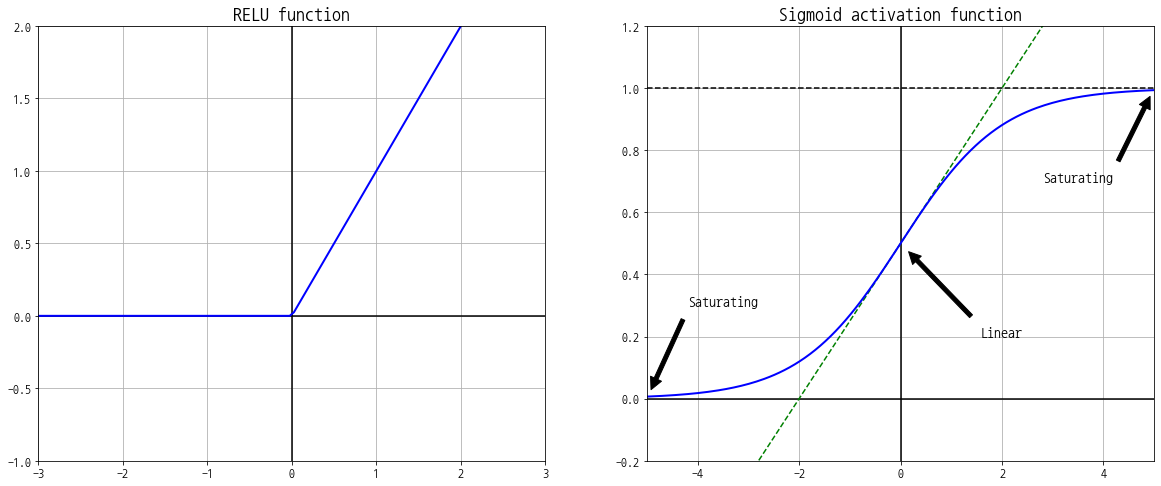

In [231]:
plt.figure(figsize=(20, 8))
z = np.linspace(-5, 5, 200)
plt.subplot(121)

plt.plot([-3, 3], [0, 0], 'k-')
plt.plot([0, 0], [-2, 2], 'k-')
plt.plot(z, logit_relu(z), "b-", linewidth=2)
plt.grid(True)
plt.title("RELU function", fontsize=18)
plt.axis([-3, 3, -1, 2], "equal")



plt.subplot(122)
z = np.linspace(-5, 5, 200)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit_sigmoid(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=18)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

```python
Dense(16, activation="relu")
```
16개의 은닉 유닛이 있다는 것은 가중치 행렬 W의 크기가 (input_dimension, 16)이라는 뜻입니다. 입력 데이터와 W를 점곱하면 입력 데이터가 16 차원으로 표현된 공간으로 투영됩니다(그리고 편향 벡터 b를 더하고 relu 연산을 적용합니다). 표현 공간의 차원을 '신경망이 내재된 표현을 학습할 때 가질 수 있는 자유도'로 이해할 수 있습니다. 은닉 유닛을 늘리면 (표현 공간을 더 고차원으로 만들면) 신경망이 더욱 복잡한 표현을 학습할 수 있지만 계산 비용이 커지고 원치 않은 패턴을 학습할 수도 있습니다(훈련 데이터에서는 성능이 향상되지만 테스트 데이터에서는 그렇지 않은 패턴입니다).

Dense 층을 쌓을 때 두 가진 중요한 구조상의 결정이 필요합니다:

- 얼마나 많은 층을 사용할 것인가
- 각 층에 얼마나 많은 은닉 유닛을 둘 것인가

모델은 다음의 층으로 구성합니다.  
- 16개의 은닉 유닛을 가진 두 개의 은닉층
- 현재 리뷰의 감정을 스칼라 값의 예측으로 출력하는 세 번째 층
중간에 있는 은닉층은 활성화 함수로 relu를 사용하고 마지막 층은 확률(0과 1 사이의 점수로, 어떤 샘플이 타깃 '1'일 가능성이 높다는 것은 그 리뷰가 긍정일 가능성이 높다는 것을 의미합니다)을 출력하기 위해 시그모이드 활성화 함수를 사용합니다. relu는 음수를 0으로 만드는 함수입니다. 시그모이드는 임의의 값을 [0, 1] 사이로 압축하므로 출력 값을 확률처럼 해석할 수 있습니다.

다음이 이 신경망의 모습입니다:

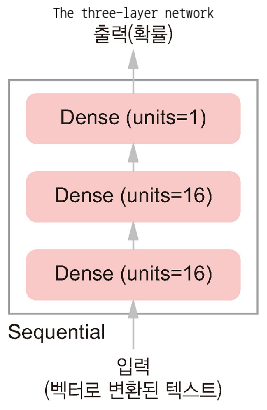

In [232]:
plt.figure(figsize=(12, 7))
plt.title("The three-layer network", fontsize=14)
plot_external2("./images/ch02/2.png")
plt.show()

In [256]:
from tensorflow.keras.layers import Dense

model = tf.keras.Sequential()
model.add(Dense(16, activation="relu", input_shape=(10000,)))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

<br> 
마지막으로 손실 함수와 옵티마이저를 선택해야 합니다. 이진 분류 문제고 신경망의 출력이 확률이기 때문에(네트워크의 끝에 시그모이드 활성화 함수를 사용한 하나의 유닛으로 된 층을 놓았습니다), binary_crossentropy 손실이 적합합니다. 또한 mean_squared_error도 사용할 수 있습니다. 확률을 출력하는 모델을 사용할 때는 binary_crossentropy가 최선의 선택입니다. 크로스엔트로피는 정보이론 분야에서 온 개념으로 확률 분포 간의 차이를 측정합니다. 여기에서는 원본 분포와 예측분포 사이를 측정합니다.  

다음은 옵티마이저와 binary_crossentropy손실 함수로 모델을 설정하는 단계입니다.

In [257]:
from tensorflow.keras import optimizers, losses, metrics

model.compile(optimizer=optimizers.Adam(lr=0.001), loss= losses.binary_crossentropy, metrics=[metrics.binary_accuracy])

<br>

### 2.5.4 Validating your approach

신경망에 데이터를 주입하기 전에 데이터가 적절하게 나눠졌는지 확인해보겠습니다.

In [258]:
print("훈련데이터의 크기 X: {}, y: {}".format(len(X_train), len(y_train)))
print("검증데이터의 크기 X: {}, y: {}".format(len(X_valid), len(y_valid)))
print("테스트데이터의 크기 X: {}, y: {}".format(len(X_test), len(y_valid)))

훈련데이터의 크기 X: 15000, y: 15000
검증데이터의 크기 X: 10000, y: 10000
테스트데이터의 크기 X: 25000, y: 10000


<br>
이제 모델을 512개의 샘플씩 미니 배치를 만들어 20번의 에포크 동안 훈련시킵니다(X_train, y_train 텐서에 있는 모든 샘플에 대해 20번 반복합니다). 동시에 따로 떼어 놓은 1만 개의 샘플에서 손실과 정확도를 측정할 것입니다. 이렇게 하려면 validation_data 매개변수에 검증 데이터를 전달해야 합니다.

5회 에포크마다 loss를 출력하기 위한 class모듈을 만듭니다.

In [268]:
class LossAndErrorPrintingCallback(tf.keras.callbacks.Callback):
    def __init__(self, epochs):
        self.epochs = epochs
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch                
#         print('\repoch {}'.format(epoch, end=""))
              
    def on_train_batch_end(self, batch, logs=None):        
        print('\repoch: {}, loss {:.5f}'.format(self.epoch+1, logs['loss']), end=" ")
              
    def on_epoch_end(self, epoch, logs=None):        
        if epoch == 0:
            print("\thistory key: {}".format(list(logs.keys())))
        print("\repoch: {}, loss: {}".format(epoch+1, logs["loss"]), end=" ")

        if (epoch+1) % 5 == 0 or epoch+1 == self.epochs:
            print("\rEpoch {}/{}".format(epoch+1, self.epochs), end=" ")
            print("loss: {:.5f}".format(logs["loss"]), end=" ")
            print("acc: {:.5f}".format(logs["binary_accuracy"]), end=" ")
            print("val_loss: {:.5f}".format(logs["val_loss"]), end=" ")
            print("val_acc: {:.5f}".format(logs["val_binary_accuracy"]))

In [260]:
history = model.fit(X_train, y_train, epochs=20, batch_size=512, validation_data=(X_valid, y_valid), verbose=0, callbacks=[LossAndErrorPrintingCallback(epochs=20)])

epoch: 1, loss 0.45034 	history key: dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
Epoch 5/20 loss: 0.13525 binary_accuracy: 0.95893 val_loss: 0.28345 val_binary_accuracy: 0.88800
Epoch 10/20 loss: 0.03765 binary_accuracy: 0.99507 val_loss: 0.39816 val_binary_accuracy: 0.87790
Epoch 15/20 loss: 0.00922 binary_accuracy: 0.99980 val_loss: 0.52327 val_binary_accuracy: 0.87050
Epoch 20/20 loss: 0.00331 binary_accuracy: 0.99993 val_loss: 0.61253 val_binary_accuracy: 0.86930


In [261]:
history_dict = history.history

In [262]:
import matplotlib.pyplot as plt

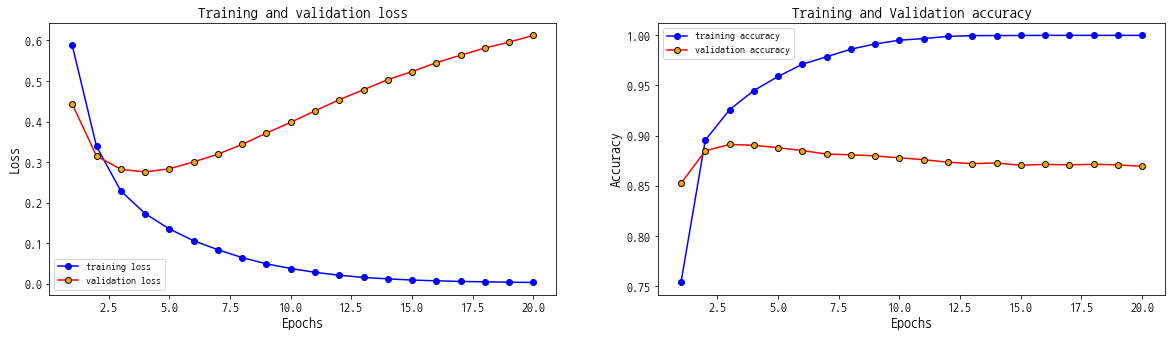

In [264]:
# ['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy']
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

acc = history_dict["binary_accuracy"]
val_acc = history_dict["val_binary_accuracy"]

epochs = range(1, len(loss)+1)

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(epochs, loss, "bo-", label="training loss")
plt.plot(epochs, val_loss, "ro-", markerfacecolor="orange", markeredgecolor="k", label="validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc, "bo-", label="training accuracy")
plt.plot(epochs, val_acc, "ro-", markerfacecolor="orange", markeredgecolor="k", label="validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation accuracy")
plt.legend()

plt.show()

여기에서 알 수 있는 사실은 다음과 같습니다.  
- 훈련 손실이 에포크마다 **감소**하고, 훈련 정확도는 에포크마다 **증가**합니다.  
- 검증 손실과 정확도는 4번째 Epoch에서 그래프가 역전되는 것 같습니다.

이런 경우에 과대 적합을 방지하기 위해서 3번째 에포크 이후에 훈련을 중지할 수 있습니다.  

In [265]:
from tensorflow.keras.layers import Dense

model = tf.keras.Sequential()
model.add(Dense(16, activation="relu", input_shape=(10000,)))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [266]:
from tensorflow.keras import optimizers, losses, metrics

model.compile(optimizer=optimizers.Adam(lr=0.001), loss= losses.binary_crossentropy, metrics=[metrics.binary_accuracy])

In [268]:
class LossAndErrorPrintingCallback(tf.keras.callbacks.Callback):
    def __init__(self, epochs):
        self.epochs = epochs
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch                
#         print('\repoch {}'.format(epoch, end=""))
              
    def on_train_batch_end(self, batch, logs=None):        
        print('\repoch: {}, loss {:.5f}'.format(self.epoch+1, logs['loss']), end=" ")
              
    def on_epoch_end(self, epoch, logs=None):        
        if epoch == 0:
            print("\thistory key: {}".format(logs.keys()))
        print("\repoch: {}, loss: {}".format(epoch+1, logs["loss"]), end=" ")

        if (epoch+1) % 5 == 0 or epoch+1 == self.epochs::
            print("\rEpoch {}/{}".format(epoch+1, self.epochs), end=" ")
            print("loss: {:.5f}".format(logs["loss"]), end=" ")
            print("binary_accuracy: {:.5f}".format(logs["binary_accuracy"]), end=" ")
#             print("val_loss: {:.5f}".format(logs["val_loss"]), end=" ")
#             print("val_binary_accuracy: {:.5f}".format(logs["val_binary_accuracy"]))

In [269]:
history = model.fit(X_train, y_train, epochs=4, batch_size=512, verbose=0, callbacks=[LossAndErrorPrintingCallback(epochs=4)])

epoch: 1, loss 0.40511 	history key: dict_keys(['loss', 'binary_accuracy'])
epoch: 4, loss: 0.15864317242304485 

In [270]:
history_dict = history.history

In [271]:
import matplotlib.pyplot as plt

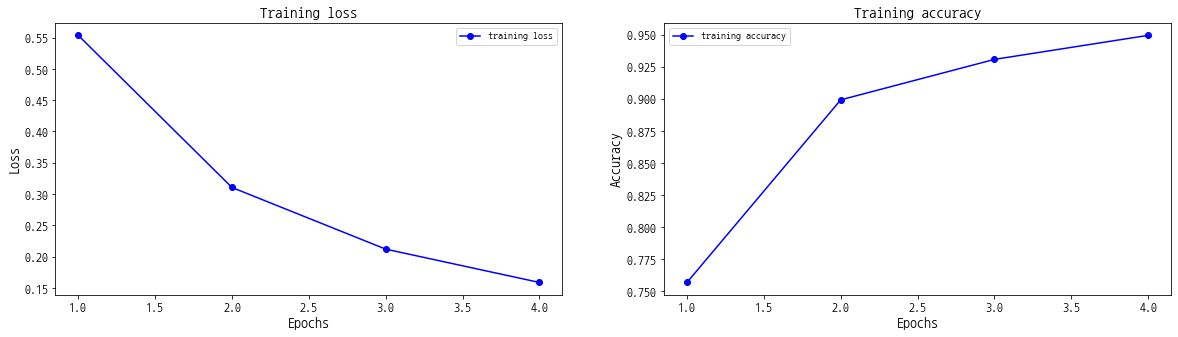

In [272]:
# ['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy']
loss = history_dict["loss"]
acc = history_dict["binary_accuracy"]

epochs = range(1, len(loss)+1)

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(epochs, loss, "bo-", label="training loss")
plt.title("Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc, "bo-", label="training accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training accuracy")
plt.legend()

plt.show()

In [273]:
results = model.evaluate(X_test, y_test)
results

25000/25000 [==============================] - 4s 161us/sample - loss: 1.7704 - binary_accuracy: 0.5010


[1.7703542577362061, 0.50096]

정확도는 50% 정도를 당성했습니다.

<br>

### 2.5.5 Using a trained network to generate predictions on new data

모델을 훈련시킨 후에 이를 실전 환경에서 사용하려면 predict 메서드를 사용하면 됩니다. predict 메서드를 사용해서 어떤 리뷰가 긍정일 확률을 예측할 수 있습니다(예측하려는 대상이 양성이 됩니다). 

In [300]:
prediction = model.predict(X_test)
prediction

array([[0.27069604],
       [0.998111  ],
       [0.90699327],
       ...,
       [0.11021167],
       [0.17159075],
       [0.58753675]], dtype=float32)

이 확률이 0.5보다 크거나 같으면 1, 그렇지 않으면 0으로 이진화 합니다.

In [301]:
binary_prediction = np.where(prediction>=0.5, 1, 0)
binary_prediction

array([[0],
       [1],
       [1],
       ...,
       [0],
       [0],
       [1]])

In [302]:
index, count = np.unique(binary_prediction, return_counts=True)

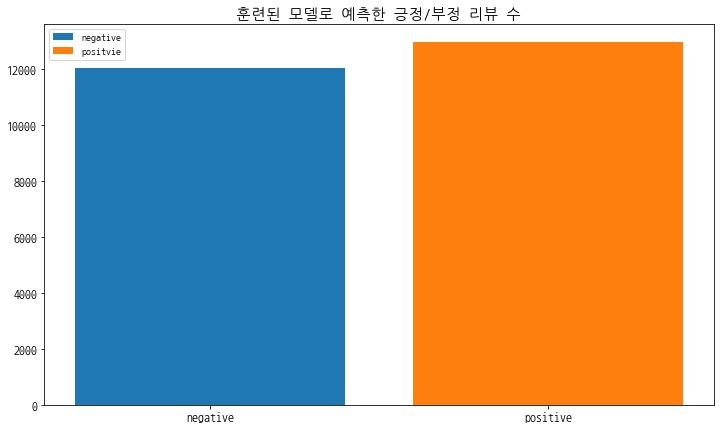

In [303]:
plt.figure(figsize=(12, 7))
plt.bar(index[0], count[0], label="negative")
plt.bar(index[1], count[1], label="positvie")
plt.legend()
plt.title("훈련된 모델로 예측한 긍정/부정 리뷰 수")
plt.xticks(index, ["negative", "positive"])
plt.show()